# style transfer
[paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
[reference](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice)

In [1]:
!nvidia-smi

Sun Mar 27 08:48:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   46C    P8    23W / 170W |    873MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
from torch import nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
def image_loader(img_path, imsize):
    loader = torchvision.transforms.Compose({
        torchvision.transforms.Resize(imsize),
        torchvision.transforms.ToTensor(),
    })
    image = PIL.Image.open(img_path)
    image = loader(image)
    return image.to(device, dtype=torch.float)

def imshow(img):
    t = img.cpu().clone()
    t = img.squeeze(0)
    t = torchvision.transforms.ToPILImage()(t)
    
    plt.imshow(t)
    plt.show()

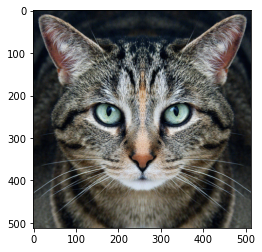

1.0
0.0


In [6]:
img_path = './data/ImageStyleTransfer/cat.jpg'
target_img = image_loader(img_path, (512, 512))
imshow(target_img)
print(target_img.to('cpu').numpy().max())
print(target_img.to('cpu').numpy().min())

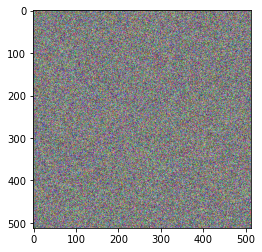

0.9999985
7.2526745e-08


In [7]:
noise_img = torch.rand_like(target_img).to(device)
imshow(noise_img)
print(noise_img.to('cpu').numpy().max())
print(noise_img.to('cpu').numpy().min())

[start]


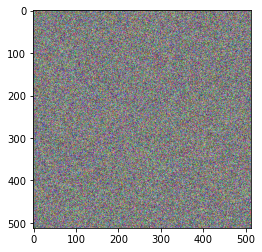

10 step
loss: 0.10442981123924255


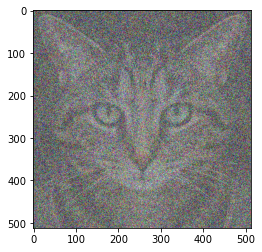

20 step
loss: 0.06238403916358948


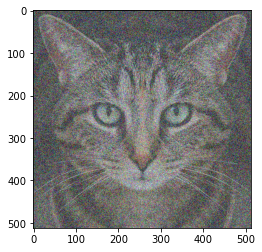

30 step
loss: 0.03726683929562569


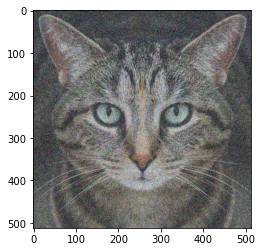

40 step
loss: 0.02226238325238228


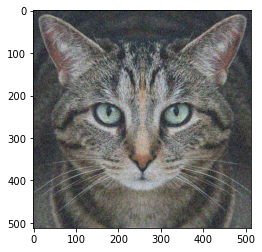

50 step
loss: 0.013299050740897655


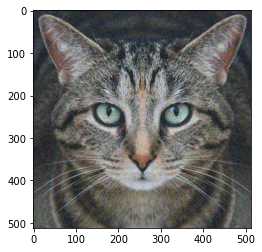

60 step
loss: 0.007944556884467602


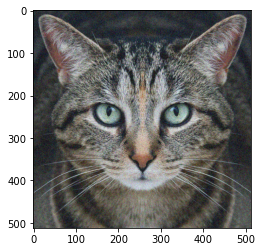

70 step
loss: 0.004745901562273502


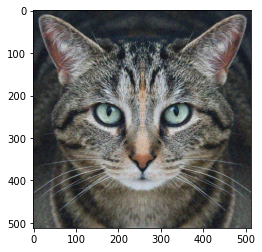

80 step
loss: 0.0028350958600640297


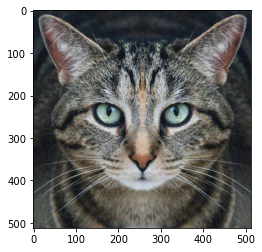

90 step
loss: 0.0016936231404542923


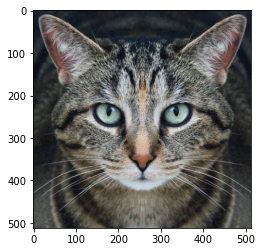

100 step
loss: 0.001011732849292457


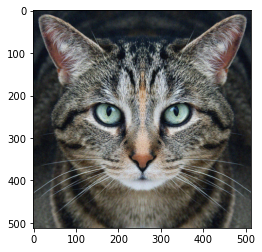

In [8]:
loss_fn = nn.MSELoss() # 왜 MSEloss?
iters = 100
lr = 1e4

noise_img.detach_()

print("[start]")
imshow(noise_img)

for i in range(iters):
    noise_img.requires_grad = True
    
    loss = loss_fn(noise_img, target_img)
    loss.backward()
    
    gradient = lr * noise_img.grad
    
#     noise = torch.clamp(noise - gradient, min=0, max=1).detach_()
    noise_img.requires_grad = False
    noise_img = noise_img - gradient
    
    if (i+1) % 10 == 0:
        print('{} step\nloss: {}'.format(i+1, loss))
        imshow(noise_img)

In [9]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()
# vgg19, vgg19_bn도 있음
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# [normalization](https://pytorch.org/vision/stable/models.html)

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [12]:
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']
def get_style_losses(cnn, style_img):
#     cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    j = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}_{}'.format(j, i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}_{}'.format(j, i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            i = 0
            name = 'pool_{}'.format(j)
            j += 1
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}_{}'.format(j, i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(torch.reshape(style_img, (1, 3, 512, 640))).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(j), style_loss)
            style_losses.append(style_loss)
            
        if(len(style_losses) == 5):
            break
    
#     print(model)
#     print(style_losses)
    
    return model, style_losses


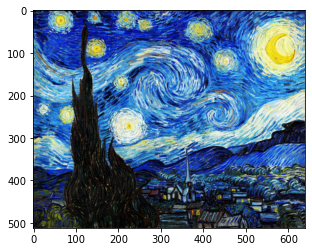

torch.Size([3, 512, 640])


In [55]:
style_img = image_loader('./data/ImageStyleTransfer/style_1.jpg', (512, 640))
imshow(style_img)
print(style_img.shape)

In [14]:
z, x = get_style_losses(cnn, style_img)

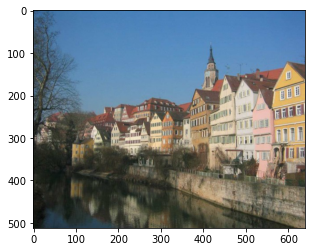

In [54]:
content_img = image_loader('./data/ImageStyleTransfer/content_1.jpg', (512, 640))
imshow(content_img)

In [129]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img)
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    
    i = [0]
    while i[0] <= iters:

        def closure():
#             input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(torch.reshape(input_img, (1, 3, 512, 640)))
            style_score = 0
            
            m = 1/5
            for sl in style_losses:
                style_score += sl.loss * m
#                 m *= 1/5

            style_score *= 1e6
            style_score.backward()

            i[0] += 1
            if i[0] % 50 == 0:
                print(f"[ Step: {i[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
#     input_img.data.clamp_(0, 1)

    return input_img

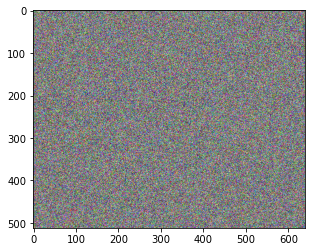

0.9999998
1.3387762e-08


In [130]:
input_img = torch.rand_like(content_img).to(device)
imshow(input_img)
print(input_img.to('cpu').numpy().max())
print(input_img.to('cpu').numpy().min())

[ Start ]


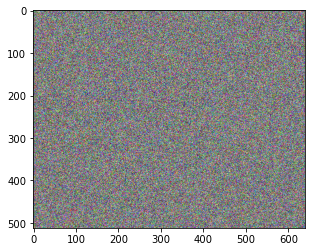

[ Step: 50 / Style loss: 173.12144470214844]


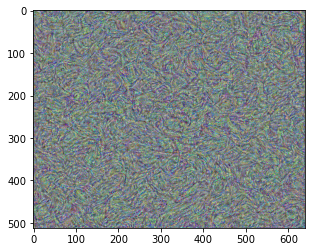

[ Step: 100 / Style loss: 50.313350677490234]


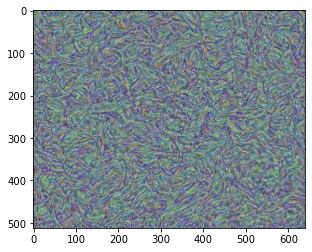

[ Step: 150 / Style loss: 23.178646087646484]


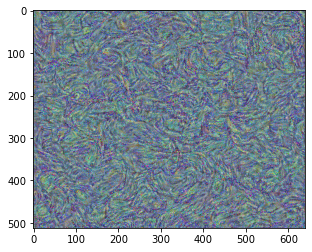

[ Step: 200 / Style loss: 12.648447036743164]


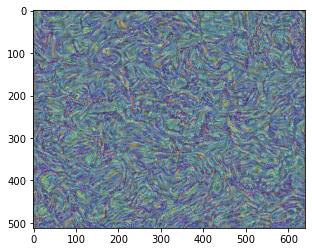

[ Step: 250 / Style loss: 8.583512306213379]


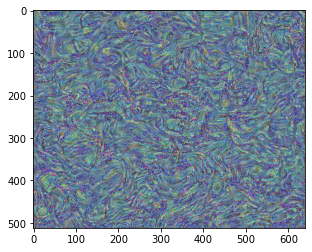

[ Step: 300 / Style loss: 6.4582648277282715]


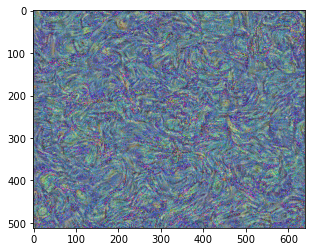

[ Step: 350 / Style loss: 5.213135719299316]


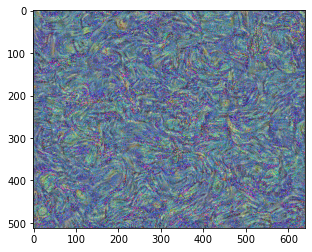

KeyboardInterrupt: 

In [131]:
output = style_reconstruction(
    cnn,
    style_img=style_img,
    input_img=input_img,
    iters=1000)

In [25]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

In [26]:
content_layers = ['relu_4_1']

# 콘텐츠 손실(content loss)을 계산하는 함수
def get_content_losses(cnn, content_img):
#     cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    j = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}_{}'.format(j, i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}_{}'.format(j, i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            i = 0
            name = 'pool_{}'.format(j)
            j += 1
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}_{}'.format(j, i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(torch.reshape(content_img, (1, 3, 512, 640))).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if len(content_losses) == 1:
            break

#     print(model)
    
    return model, content_losses

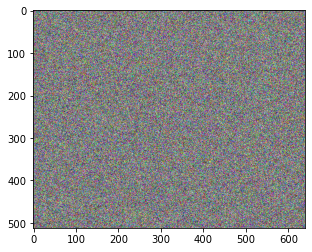

0.9999984
4.0989835e-07


In [27]:
input_img = torch.rand_like(content_img).to(device)
imshow(input_img)
print(input_img.to('cpu').numpy().max())
print(input_img.to('cpu').numpy().min())

In [28]:
get_content_losses(cnn, content_img)

(Sequential(
   (0): Normalization()
   (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_1_1): ReLU()
   (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_1_2): ReLU()
   (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_2_1): ReLU()
   (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_2_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_3_1): ReLU()
   (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_3_2): ReLU()
   (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_3_3): ReLU()
   (conv_3_4): Conv2d(256, 256, kernel_size=(3, 3), stride

In [29]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img)
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    i = [0]
    while i[0] <= iters:

        def closure():
#             input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(torch.reshape(input_img, (1, 3, 512, 640)))
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            i[0] += 1
            if i[0] % 50 == 0:
                print(f"[ Step: {i[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
#     input_img.data.clamp_(0, 1)

    return input_img

[ Start ]


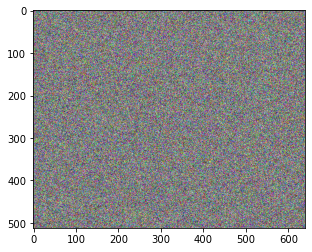

[ Step: 50 / Content loss: 1.6434379816055298]


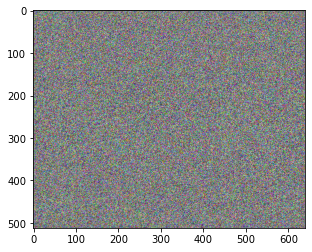

KeyboardInterrupt: 

In [30]:
output = content_reconstruction(
    cnn,
    content_img=content_img,
    input_img=input_img,
    iters=1000)

In [31]:
content_layers = ['conv_4_2']
# style_layers = ['relu_1_2', 'relu_2_2', 'relu_3_4', 'relu_4_4', 'relu_5_4']
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']
# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img):
#     cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    j = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}_{}'.format(j, i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}_{}'.format(j, i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(j)
            i = 0
            j += 1
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}_{}'.format(j, i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(torch.reshape(content_img, (1, 3, 512, 640))).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_1", content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(torch.reshape(style_img, (1, 3, 512, 640))).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(j), style_loss)
            style_losses.append(style_loss)

        if(len(style_losses) == 5):
            break

    return model, content_losses, style_losses

In [32]:
get_losses(cnn, content_img, style_img)

(Sequential(
   (0): Normalization()
   (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_1): StyleLoss()
   (relu_1_1): ReLU()
   (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_1_2): ReLU()
   (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_2): StyleLoss()
   (relu_2_1): ReLU()
   (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_2_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_3): StyleLoss()
   (relu_3_1): ReLU()
   (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu_3_2): ReLU()
   (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [164]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img)
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    i = [0]
    while i[0] <= iters:

        def closure():
#             input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(torch.reshape(input_img, (1, 3, 512, 640)))
            content_score = 0
            style_score = 0
            
            m = 1/2
            for sl in style_losses:
                style_score += sl.loss * m
                m *= 1/2
                
            for cl in content_losses:
                content_score += cl.loss

            style_score *= 500000
            loss = content_score + style_score
            loss.backward()

            i[0] += 1
            if i[0] % 100 == 0:
                print(f"[ Step: {i[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
#     input_img.data.clamp_(0, 1)

    return input_img


[ Content Image ]


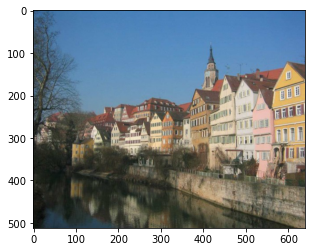

[ Style Image ]


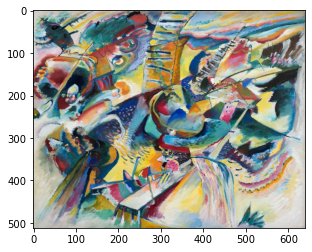

torch.Size([3, 512, 640])
[ input Image ]


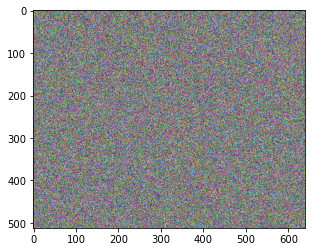

In [237]:
content_img = image_loader('./data/ImageStyleTransfer/content_1.jpg', (512, 640))
print("[ Content Image ]")
imshow(content_img)
style_img = image_loader('./data/ImageStyleTransfer/style_14.jpg', (512, 640))
print("[ Style Image ]")
imshow(style_img)
print(style_img.shape)
input_img = torch.rand_like(content_img).to(device)
print("[ input Image ]")
imshow(input_img)

[ Start ]


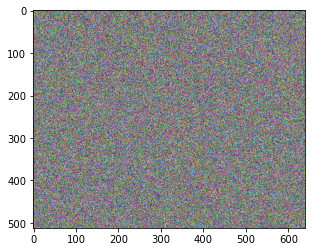

[ Step: 100 / Content loss: 39.534912109375 / Style loss: 22.98777961730957]


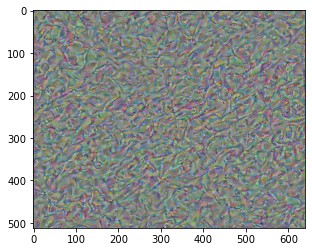

[ Step: 200 / Content loss: 26.3855037689209 / Style loss: 14.313102722167969]


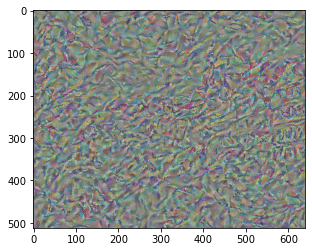

[ Step: 300 / Content loss: 22.156858444213867 / Style loss: 11.59603500366211]


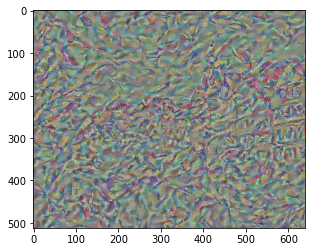

[ Step: 400 / Content loss: 20.009632110595703 / Style loss: 10.135783195495605]


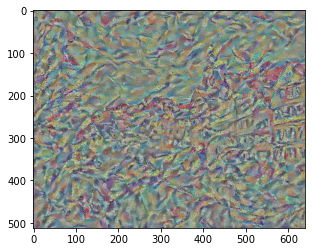

[ Step: 500 / Content loss: 18.68755340576172 / Style loss: 9.168351173400879]


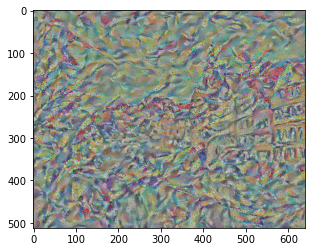

[ Step: 600 / Content loss: 17.814002990722656 / Style loss: 8.446921348571777]


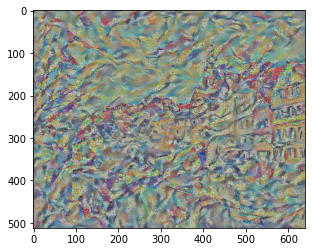

[ Step: 700 / Content loss: 17.177988052368164 / Style loss: 7.973863124847412]


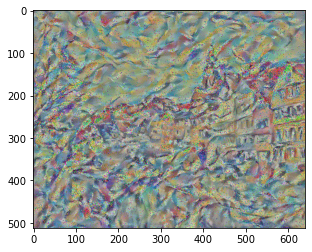

[ Step: 800 / Content loss: 16.736745834350586 / Style loss: 7.65433931350708]


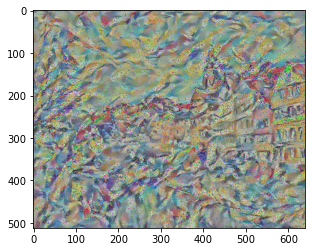

[ Step: 900 / Content loss: 16.404687881469727 / Style loss: 7.454249382019043]


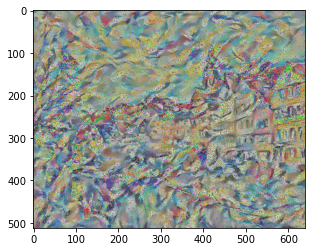

[ Step: 1000 / Content loss: 16.151077270507812 / Style loss: 7.321086406707764]


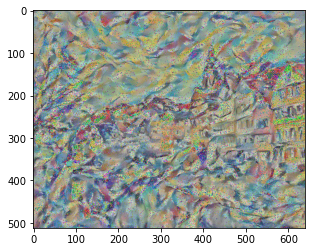

In [238]:
output = style_transfer(
    cnn,
    content_img=content_img,
    style_img=style_img,
    input_img=input_img,
    iters=1000)

In [239]:
from torchvision.utils import save_image

save_image(output.cpu().detach(), 'output_43.png')
print('이미지 파일 저장을 완료했습니다.')

이미지 파일 저장을 완료했습니다.
